In [1]:
# Enable autoreload of module
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from vector_quantize_pytorch import VectorQuantize
import os
from data.neural_field_datasets import MnistNeFDataset, TokenTransform
from training import training_nano_gpt
from networks.nano_gpt import GPTConfig

torch.cuda.is_available()

/home/luca/.cache/pypoetry/virtualenvs/adl4cv-OvNqwVNf-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


True

In [3]:
kwargs = {
"type": "pretrained",
"fixed_label": 5,
}

dir_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(dir_path, "adl4cv")

# load used vector quantizer
vq_dicts = torch.load(os.path.join(data_root, "models", "vqs", "vq_mnist.pt"))
vq = VectorQuantize(**vq_dicts["vq_config"])
vq.load_state_dict(vq_dicts["state_dict"])

dataset = MnistNeFDataset(os.path.join(data_root, "datasets", "mnist-nerfs"), transform=TokenTransform(vq), **kwargs)

In [4]:
# Config Training
config = training_nano_gpt.Config()
config.learning_rate= 1e-3
config.max_iters = 20000
config.weight_decay=0
config.decay_lr=True
config.lr_decay_iters=config.max_iters
config.warmup_iters=0.05*config.max_iters
config.batch_size = 16
config.gradient_accumulation_steps = 1
config.init_from = "scratch"
config.out_dir ="models/token_transformer"
config.detailed_folder = "training_sample_5"
config.eval_interval = 250

model_config = GPTConfig(n_embd=336, block_size=len(dataset[0][0]), n_head=12, n_layer=12, vocab_size=vq_dicts["vq_config"]["codebook_size"] + 1)

In [8]:
# Where to put?
# Maybe adjust dataset to be able to work with splitting data and then rewrite TokenTransform 
# to do the job combined with pytorch dataloader (get_batch == __call__ of Dataloader)
def get_batch_lambda(n, config, dataset, model_config, split):
    batch_size = config.batch_size
    
    # Generate random indices for batch selection
    indices = torch.randint(0, n, (batch_size,))
    
    # Initialize lists to hold the sequences and labels
    samples = []
    labels = []

    # Collect samples and labels
    for idx in indices:
        sample, label = dataset[idx]
        sos_token = torch.Tensor([0]).long()  # Start of sequence token
        sample = torch.cat((sos_token, sample), dim=0)
        samples.append(sample)
        labels.append(label)

    # Prepare the sequences for model input
    max_len = samples[0].size(0)
    x = torch.zeros((batch_size, max_len - 1), dtype=torch.long)
    y = torch.zeros((batch_size, max_len - 1), dtype=torch.long)
    
    for i, sample in enumerate(samples):
        end_index = sample.size(0) - 1
        x[i, :end_index] = sample[:-1]  # Exclude the last token for x
        y[i, :end_index] = sample[1:]   # Exclude the first token for y

    # Ensure x and y are the correct shape (batch_size, block_size) if needed:
    # Here, we truncate to `block_size` if samples are longer than `block_size`.
    x = x[:, :model_config.block_size]
    y = y[:, :model_config.block_size]

    # x and y have to be
    x = x.to(config.device)
    y = y.to(config.device)

    return x, y

create_get_batch = lambda n, config, dataset, model_config: lambda split: get_batch_lambda(n, config, dataset, model_config, split)
get_batch = create_get_batch(1553, config, dataset, model_config)

In [10]:
# Prepeare model parameters and train
trained_model = training_nano_gpt.train(get_batch, config, model_config, vq, vq_dicts["vq_config"])

Initializing a new model from scratch
number of parameters: 16.48M
num decayed parameter tensors: 50, with 16,628,304 parameters
num non-decayed parameter tensors: 98, with 53,088 parameters
using fused AdamW: True
step 0: train loss 6.4765, val loss 6.4759
step 250: train loss 3.8931, val loss 3.9128
saving checkpoint to models/token_transformer


KeyboardInterrupt: 

In [11]:
import matplotlib.pyplot as plt
import torch
from networks.nano_gpt import GPT
from utils import get_default_device

model_dict = torch.load("./models/token_transformer/ckpt.pt")
# Configuration
idx = 3

device = get_default_device()
model = GPT(model_dict["model_args"])
model.to(device=device)
model.load_state_dict(model_dict["model"])
model.eval()


sample = dataset[0][0]
X, Y = get_batch("")
X, Y = (X[0].unsqueeze(0), Y[0].unsqueeze(0))
pred, _ = model(X, Y)
# Sanity Check
# Should be all true except first/second element
pred.argmax(dim=-1)==Y


number of parameters: 4.26M


tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, F

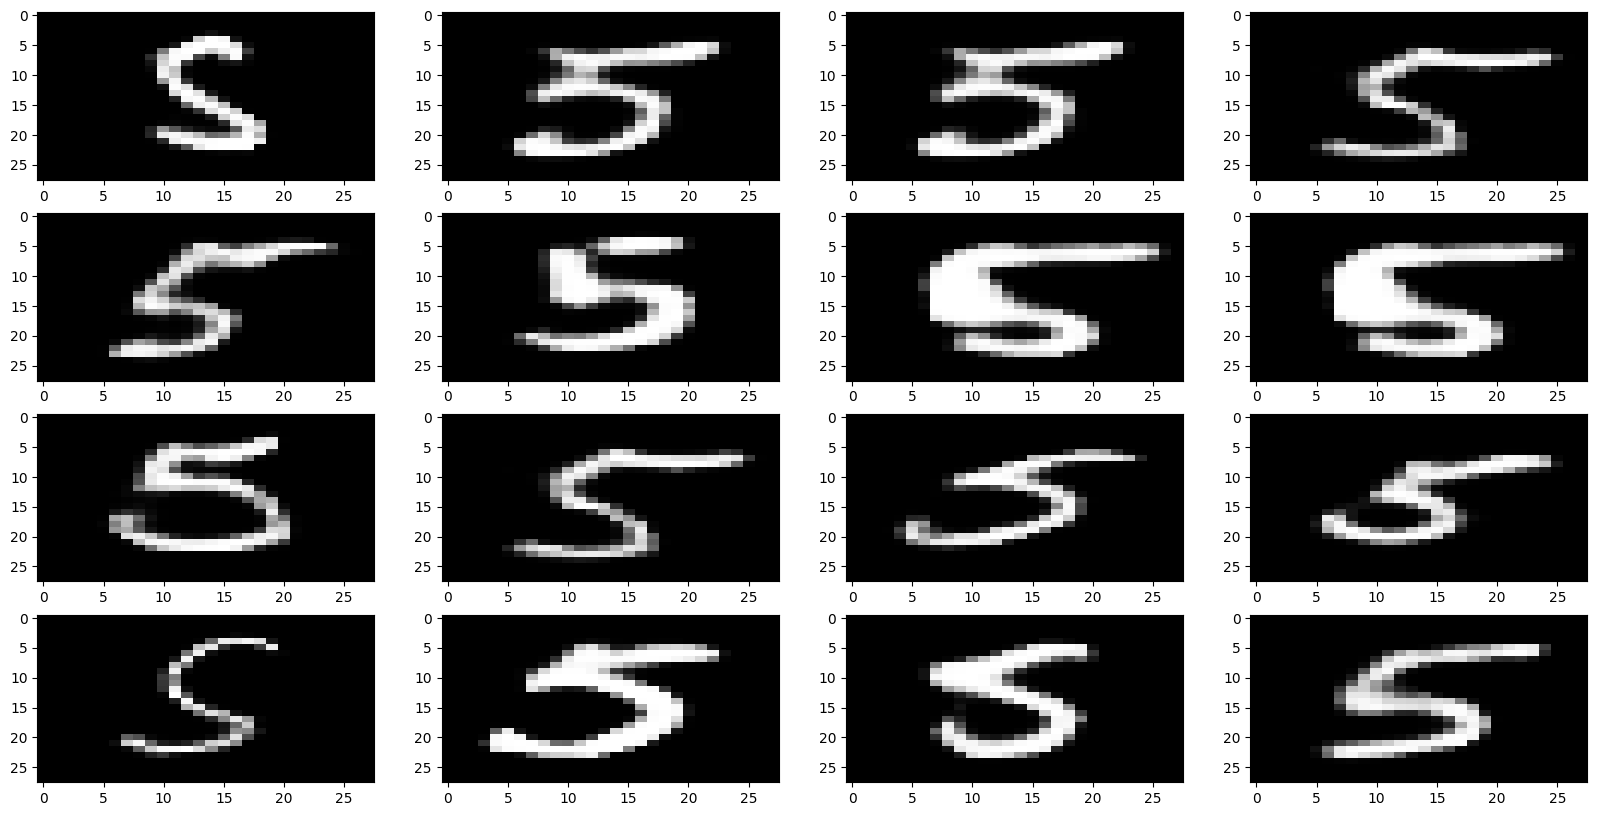

In [15]:
from animation.util import backtransform_weights, reconstruct_image
from networks.mlp_models import MLP3D

ij_len = 4
# Plotting the tensors as heatmaps in grayscale
fig, axes = plt.subplots(ij_len, ij_len, figsize=(20, 10))

SOS = torch.Tensor([[0]]).long().to(device)

for i in range(ij_len):
    for j in range(ij_len):

        model.eval()
        novel_tokens = model.generate(SOS, 593, temperature=1.0, top_k=10)[:, 1:].unsqueeze(-1).to("cpu")
        novel_weights= vq.get_codes_from_indices((novel_tokens-1))

        dataset_no_transform = MnistNeFDataset(os.path.join(data_root, "datasets", "mnist-nerfs"), **kwargs)
        original_dict = dataset_no_transform[0][0]

        reconstructed_dict = backtransform_weights(novel_weights, original_dict["state_dict"])

        mlp3d = MLP3D(**original_dict["model_config"])
        mlp3d.load_state_dict(reconstructed_dict)
        reconstructed_tensor = reconstruct_image(mlp3d)

        axes[i][j].imshow(reconstructed_tensor, cmap='gray', aspect='auto')

plt.show()